Fastq files and the pre-processing steps were assessed for quality control using the FastQC and multiQC programs. First, we aim to remove UMI sequences from the Illumina reads using the `umi_tools extract` command. Then, we use Cutadapt to remove low quality and short reads. Using the STAR aligner (Dobin et al., 2013), Fastq files were aligned against the GENCODE v.34 human reference genome. We aimed to process BAM files from the STAR run using `umi_tools dedup` to detect duplicate reads. Gene level counts measured using the HTSeq package. STAR and HTSeq command options selected as suggested in the QuantSeq FWD kit data analysis manual. 

> The way this experiment works is that I start with human pluripotent stem cells and then start the differentiation by supplying the media with growth factors that induce the desired cell fate, in this particular case it’s definitive endoderm - anterior foregut - lung progenitors - lung organoids.

> **Day0** corresponds to **stem cell state**, while the later days correspond to the moments where I change growth factors and expect different cellular fates. Usually, I don’t need the information from the intermediate timepoints, I grow these cells for 50 days and then do experiments with it. However, for quality control purposes (to see that the intermediate fates are correct), I did one experiment where I collected these **intermediate timepoints**. So, experimentally, I collected Day0 to Day35 from one differentiation, and then I have several separate experiments where I started with Day50 cells. In one of the experiments, I did it at Day55. So my idea was while each time point has duplicates, the last time point, or **“mature organoids”**, would exist in more replicates. The “no cells” samples are Day50 organoids, they’re called no cells as I didn’t put them with cancer cells.

I thinks we could label samples like this:
- Day == 0 => stem_cell
- 0 < Day < 35 => intermediate
- 50 <= Day <= 55 => mature_organoids

Using these labels, we are able to compare samples in these conditions (i.e. stem_cell vs. mature_organoids OR mature_organoids vs. intermediate) for usual differential experssion analysis and then, we can also run iPAGE for enrichment analysis to compare these cell states. 

There are other packages especially designer for time-series experiments. See [this paper](https://doi.org/10.1016/j.csbj.2015.08.004)

# Raw data 
I've renamed fastq files accordingly. 

In [2]:
ls fastq

HLO-D0_r1.fastq.gz*   HLO-D35_r1.fastq.gz*  HLO-D9_r1.fastq.gz*
HLO-D0_r2.fastq.gz*   HLO-D35_r2.fastq.gz*  HLO-D9_r2.fastq.gz*
HLO-D15_r1.fastq.gz*  HLO_D55_r1.fastq.gz*  HLO_no_cells_1_r1.fastq.gz*
HLO-D15_r2.fastq.gz*  HLO_D55_r2.fastq.gz*  HLO_no_cells_1_r2.fastq.gz*
HLO-D25_r1.fastq.gz*  HLO-D5_r1.fastq.gz*   HLO_no_cells_2_r1.fastq.gz*
HLO-D25_r2.fastq.gz*  HLO-D5_r2.fastq.gz*   HLO_no_cells_2_r2.fastq.gz*


Verify Files with MD5 Checksum - https://www.tecmint.com/generate-verify-check-files-md5-checksum-linux/

In [22]:
%%bash 
md5sum fastq/*fastq.gz > checksum-fastq.txt

In [25]:
cat checksum-fastq.txt

54b174440a2793e41e8e8c6c49b97805  fastq/HLO-D0_r1.fastq.gz
ddff59e1c52106c4a3b02a67d42c87c9  fastq/HLO-D0_r2.fastq.gz
a6c6338b80e5e7d7812e0331f59c39a7  fastq/HLO-D15_r1.fastq.gz
82911afe8d4187e10d466e6d2e00c1b1  fastq/HLO-D15_r2.fastq.gz
d9151690db54a93168e20110741715f5  fastq/HLO-D25_r1.fastq.gz
109e93d67db787f3bdbbb13520349da2  fastq/HLO-D25_r2.fastq.gz
e2d43faa0cd1e7c0b6c3fc2f679b8fa2  fastq/HLO-D35_r1.fastq.gz
1f3cc7e89f8ea2424ac8ee91c4086800  fastq/HLO-D35_r2.fastq.gz
dbb0a29d974e9405e32b600d5ac5f047  fastq/HLO_D55_r1.fastq.gz
a18f6cdf35c34755167f5ba512537431  fastq/HLO_D55_r2.fastq.gz
0706154e1a8fedc42ea673b6da2acafc  fastq/HLO-D5_r1.fastq.gz
4ee9ca341677e6dc72483c30edee0898  fastq/HLO-D5_r2.fastq.gz
02db6a6b85cf0ba9cb7aa82566ba6f9e  fastq/HLO-D9_r1.fastq.gz
842bcc2bd5b3a8ad1ba984c18dc9cd4a  fastq/HLO-D9_r2.fastq.gz
65ded9451cd4331c5bae29c3f38b3934  fastq/HLO_no_cells_1_r1.fastq.gz
389a0c03f8ca86bf7657b70014ee03da  fastq/HLO_no_cells_1_r2.fastq.gz
8b605fbb882cf169e56afd09c7a2830c

--- 

I have a conda envirnment named `alignment` where I ran these `bash` commands. See this https://github.com/abearab/QuantSeq-FWD-with-UMIs

## Trimming and alignment while removing UMI duplicates 

The 1st 6nt are UMI. So, we aim to remove UMI sequences from the Illumina reads using the [`umi_tools extract`](https://umi-tools.readthedocs.io/en/latest/QUICK_START.html#step-3-extract-the-umis). Then, we use [`cutadapt`](https://github.com/marcelm/cutadapt) with `-u` option to trim 12 nt and also, remove low quality and short reads. 


In [60]:
cat process_fastq.sh

JOBS=12

mkdir -p fastq-processed/umi_extract;
mkdir -p fastq-processed/trim;
mkdir -p logs/umi_tools_extract;

for f in `ls fastq/*`; do
    b=`basename $f`;
    l=${b/.fastq.gz/.log};

    umi_tools extract --bc-pattern=NNNNNN \
    --stdin=$f \
    --log=logs/umi_tools_extract/$l \
    --stdout fastq-processed/umi_extract/$b

    cutadapt -j $JOBS -q 15 -m 20 -u 12 \
    -o fastq-processed/trim/$b fastq-processed/umi_extract/$b;

done



## `STAR`

In [65]:
cat alignment.sh

PDIR=$1
fastqDIR=$2
JOBS=$3

INDEX='/rumi/shams/abe/genomes/hg38/gencode.v34/star_index'

cd $PDIR

mkdir -p bam
mkdir -p logs/star_aligner

STAR --genomeLoad LoadAndExit --genomeDir $INDEX

for fq_file in ${fastqDIR}/*.fastq.gz; do
    fq_base=`basename $fq_file`
    sample_id=${fq_base/.fastq.gz/}

    echo '--------------' $sample_id '--------------'

    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN $JOBS \
    --genomeDir $INDEX \
    --readFilesIn $fq_file \
    --outFileNamePrefix bam/$sample_id;

    mv -v bam/${sample_id}Aligned.sortedByCoord.out.bam bam/${sample_id}.bam
    mv -v bam/${sample_id}Log.final.out logs/star_aligner/
    rm -v bam/${sample_id}*out*
done

STAR --genomeLoad Remove --genomeDir $INDEX

rm -r _STARtmp/ Log.out Log.progress.out


## Process `bam` files 

I got a same error as discussed here - https://github.com/CGATOxford/UMI-tools/issues/389. So, I included `samtools index -@ $JOBS $bam_file` line which index bam files. 

In [3]:
cat umi_dedup.sh

PDIR=$1
bamDIR=$2
JOBS=$3

cd $PDIR

mkdir -p bam-processed/
mkdir -p logs/umi_tools_dedup;

for bam_file in ${bamDIR}/*.bam; do
    fq_base=`basename $bam_file`
    sample_id=${fq_base/.bam/}

    echo '--------------' $sample_id '--------------'

    samtools index -@ $JOBS $bam_file

    umi_tools dedup \
    --output-stats=logs/umi_tools_dedup/${sample_id}.log \
    --stdin=bam/${sample_id}.bam \
    --stdout=bam-processed/${sample_id}.bam

done


# Downstream analysis 

## Basic `DESeq2` analysis 


In [3]:
%reload_ext rpy2.ipython

In [6]:
%%R 
library (GenomicFeatures)
library (tximport)
library (tidyverse)
library (ggplot2)
library (ggrepel)
library (DESeq2)
library (patchwork)
library (BiocParallel)

register(MulticoreParam(4))

In [7]:
%%R 
ggplot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title=''){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    ## Volcano plot
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
    #         xlim(c(-20,20)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
}

geneID to geneName - https://www.biostars.org/p/196367/

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @ Part 1. read annotations @
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [8]:
%%R 
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

    # @@@@@@@@@@@@@@@@@@@@@@
    # @ Part 2: read  data @
    # @@@@@@@@@@@@@@@@@@@@@@

Import `htseq-count` results into R. 

https://www.biostars.org/p/343138/

In [9]:
%%R 
sampleFiles <- gsub(".bam","",list.files(path='bam-processed',full.names=FALSE))

time = unlist(lapply(c(55,50,50,0,15,25,35,5,9),rep,2))
rep = c(rep(c('r1','r2'), 2), 'r3', 'r4', rep(c('r1','r2'), 6) )

sampleTable <- data.frame(
    sampleName=paste('HLO',time,rep,sep='-'),
    fileName=paste0(sampleFiles,'.txt'),
#     cell = cell,
    time = time,
    rep = rep
)

sampleTable = sampleTable[order(sampleTable$time),] %>% remove_rownames
sampleTable = sampleTable[-c(17,18,13,14),]

sampleTable

   sampleName              fileName time rep
1    HLO-0-r1         HLO-D0_r1.txt    0  r1
2    HLO-0-r2         HLO-D0_r2.txt    0  r2
3    HLO-5-r1         HLO-D5_r1.txt    5  r1
4    HLO-5-r2         HLO-D5_r2.txt    5  r2
5    HLO-9-r1         HLO-D9_r1.txt    9  r1
6    HLO-9-r2         HLO-D9_r2.txt    9  r2
7   HLO-15-r1        HLO-D15_r1.txt   15  r1
8   HLO-15-r2        HLO-D15_r2.txt   15  r2
9   HLO-25-r1        HLO-D25_r1.txt   25  r1
10  HLO-25-r2        HLO-D25_r2.txt   25  r2
11  HLO-35-r1        HLO-D35_r1.txt   35  r1
12  HLO-35-r2        HLO-D35_r2.txt   35  r2
15  HLO-50-r3 HLO_no_cells_2_r1.txt   50  r3
16  HLO-50-r4 HLO_no_cells_2_r2.txt   50  r4


> `sampleTable` for htseq-count: a data.frame with three or more columns. Each row describes one sample. The first column is the sample name, the second column the file name of the count file generated by htseq-count, and the remaining columns are sample metadata which will be stored in colData - [link](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/DESeqDataSet-class)

In [10]:
%%R 
ddsHTSeq <- DESeqDataSetFromHTSeqCount(
    sampleTable = sampleTable,
    directory = 'htseq-count',
    design= ~ time
)

R[write to console]: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



In [11]:
%%R 
dds0 <- DESeq(ddsHTSeq, test="LRT", reduced=~1, parallel=TRUE)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



Normalized counts:

In [12]:
%%R 
ncu0 <- counts(dds0, normalized=TRUE) %>% data.frame %>% 
    rownames_to_column('gene_id') %>% 
    add_column(gene_name=gene2name[rownames(ddsHTSeq),], .after='gene_id')

In [16]:
%%R 
ncu0 %>% head 

             gene_id gene_name    HLO.0.r1   HLO.0.r2  HLO.5.r1   HLO.5.r2
1 ENSG00000000003.15    TSPAN6 247.6995931 257.538422 112.48314 124.834915
2  ENSG00000000005.6      TNMD   0.0000000   0.000000   0.00000   0.000000
3 ENSG00000000419.12      DPM1  48.2737226  59.587321  42.90594  45.810978
4 ENSG00000000457.14     SCYL3   8.7050975   9.089591  20.87316  18.324391
5 ENSG00000000460.17  C1orf112  20.5756851  20.199092   3.47886   9.162196
6 ENSG00000000938.13       FGR   0.7913725   1.009955   0.00000   0.000000
    HLO.9.r1   HLO.9.r2 HLO.15.r1 HLO.15.r2 HLO.25.r1  HLO.25.r2  HLO.35.r1
1 779.668035 699.045707 393.05989 404.43323 372.91064 331.426453 277.518039
2   1.976345   0.000000   0.00000   0.00000   0.00000   0.000000   0.000000
3  42.491414  23.521053  24.97951  46.18710  60.52841  56.371655  37.904903
4  30.633345  30.106948  24.97951  24.86998  13.91458  22.354277  24.367438
5   4.940862   9.408421  28.65296  24.27784   5.56583   7.775401   6.091859
6   0.000000   0.00

In [13]:
%%R 
write.table(ncu0,'deseq/norm_counts.txt', sep="\t", quote=FALSE)

Filter out non-informative gene counts:

In [14]:
%%R 
# all samples with a count of higher than 10
keep <- rowSums(counts(ddsHTSeq) > 10) == ncol(ddsHTSeq)

dds1 <- ddsHTSeq[keep,]
dds1 <- DESeq(dds1, test="LRT", reduced=~1, parallel=TRUE)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 4 workers

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates, fitting model and testing: 4 workers



In [15]:
%%R 
ncu1 <- counts(dds1, normalized=TRUE) %>% data.frame %>% 
    rownames_to_column('gene_id') %>% 
    add_column(gene_name=gene2name[rownames(dds1),], .after='gene_id')

In [16]:
%%R 
write.table(ncu1,'deseq/norm_counts_filter.txt', sep="\t", quote=FALSE)

## Clustering 

### Most variable genes 


For heatmap visualizations (Figures), Normalized counts extracted from the DESeq object, genes with less than 10 counts in all samples were removed as low expressed genes, and also, normalized across samples (SD = 1, mean ~=0) for each gene. 



In [18]:
%%R 
library(RColorBrewer)
library(pheatmap)

In [19]:
%%R 

# mostVar Calculate the top n most variable genes in a matrix of gene expression data
mostVar <- function(data, n_hits, i_want_most_var = TRUE) { 
    # https://rdrr.io/github/abc-igmm/transcripTools/man/mostVar.html
    # evaluate variance 
    data.var <- apply(data, 1, stats::var)
    # order by variance and return 
    data <- data[order(data.var, decreasing = i_want_most_var)[1:n_hits],] 
    
    return (data)
}

- https://www.biostars.org/p/205417/
- https://www.datanovia.com/en/lessons/heatmap-in-r-static-and-interactive-visualization/

### Z-normalize rows

- https://www.biostars.org/p/112498/
- https://stackoverflow.com/questions/19384582/calculating-z-scores-in-r

- https://davetang.org/muse/2018/05/15/making-a-heatmap-in-r-with-the-pheatmap-package/
        cal_z_score <- function(x){
          (x - mean(x)) / sd(x)
        }

        data_subset_norm <- t(apply(data_subset, 1, cal_z_score))
        my_hclust_gene <- hclust(dist(data_subset), method = "complete")


In [20]:
%%R 
d0 = counts(dds0, normalized=TRUE)

z0 = scale(t(d0))

d1 = counts(dds1, normalized=TRUE)

z1 = scale(t(d1))

In [21]:
%%R 
apply(d1, 1, sd) %>% as.numeric %>% head 

[1] 204.99801  17.07613  12.08680  28.92891  25.77852  12.04678


In [22]:
%%R 
apply(t(z1), 1, sd) %>% as.numeric %>% head 

[1] 1 1 1 1 1 1


In [23]:
%%R 
sd (z0[,'ENSG00000000419.12'])

[1] 1


http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf

In [33]:
%%R 
colors <- seq(-1,1,by=0.01)
my_palette <- c("dodgerblue",colorRampPalette(colors = c("dodgerblue", "ghostwhite", "firebrick1"))
                                                   (n = length(colors)-3), "firebrick1")


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



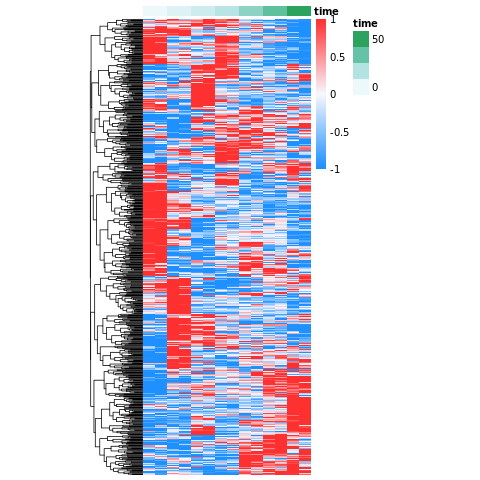

In [37]:
%%R 
z = z1

# select mostVar genes 
data = mostVar(data=t(z), n_hits=600, TRUE)

ann = data.frame(time=sampleTable$time, row.names=sampleTable$sampleName)

rownames(ann) <- colnames(data) 


h1 <- pheatmap(
    data, 
    labels_row = gene2name[data %>% rownames,],
    color = my_palette, 
    breaks = colors, 
    angle_col= 45,
    cluster_col=FALSE,
    cellwidth = 12,
    show_rownames=FALSE,
    annotation_col = ann,
    show_colnames=FALSE,
    annotation_legend=TRUE,
#     margin = c(5,5)
)

ggplot_Save(h1,'deseq/mostVar_Heatmap')

### Marker genes

In [42]:
%%R
Marker_genes <- read.csv('Marker_genes.txt', sep = '\t')

for (ge in Marker_genes$Gene){
    gene_id = rownames(gene2name)[gene2name$gene_name == ge]
    Marker_genes$gene_id[Marker_genes$Gene == ge] = gene_id[1]
}

Marker_genes <- Marker_genes %>% column_to_rownames('gene_id')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



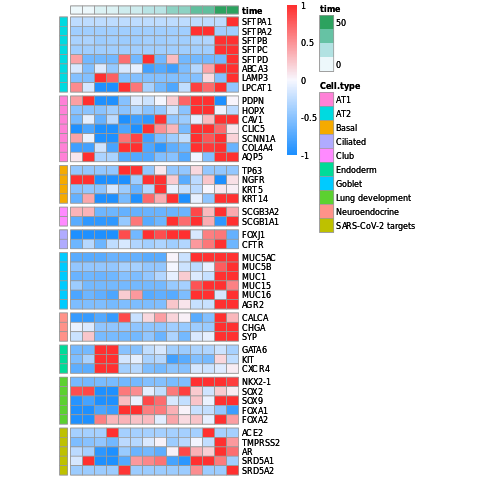

In [67]:
%%R
z = z0

# marker genes 
data = t(z)[rownames(Marker_genes),]

data = data[!rowSums(is.na(data)) > 0,]

ann_row = Marker_genes[!rowSums(is.na(data)) > 0,]
ann_col = data.frame(time=sampleTable$time, row.names=sampleTable$sampleName)

rownames(ann_col) <- colnames(data)

h1 <- pheatmap(
    data, 
    labels_row = gene2name[data %>% rownames,],
    show_colnames=FALSE,
#     angle_col= 45,
#     cellheight=10,
    color = my_palette, 
    breaks = colors, 
    cluster_col=FALSE,
    cluster_row=FALSE,
    cellwidth = 12,
    gaps_row = c(8, 15, 19, 21, 23, 29, 32, 35, 40),
    fontsize = 8,
    annotation_names_row = FALSE,
    annotation_row = select(ann_row, 1),
    annotation_col = ann_col
)
ggplot_Save(h1,'deseq/Marker_genes_Heatmap')

h1

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @ Part 3: Principal component analysis @
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

### Principal Component Analysis (PCA)
HTSeq counts processed using the DESeq2 package and a DESeq object contain all samples created. First, the `varianceStabilizingTransformation` function from DESeq2 used for the Principal Component Analysis (PCA). The first three PCs were selected for a 3-D scatter plot visualization using the R-Plotly package. 


In [89]:
%%R 
vsd <- varianceStabilizingTransformation(ddsHTSeq)

3D PCA Plot - https://support.bioconductor.org/p/66404/

https://rdrr.io/bioc/affycoretools/man/plotPCA.html

https://www.biostars.org/p/333436/

https://plotly.com/r/using-r-in-jupyter-notebooks/

https://github.com/plotly/plotlyhtmlexporter

In [90]:
%%R 
library(plotly)

plotPCA3D <- function (object, intgroup = "condition", ntop = 5000, returnData = FALSE){
  rv <- rowVars(assay(object))
  select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca <- prcomp(t(assay(object)[select, ]))
  percentVar <- pca$sdev^2/sum(pca$sdev^2)
  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }
  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop = FALSE])
  group <- if (length(intgroup) > 1) {
    factor(apply(intgroup.df, 1, paste, collapse = " : "))
  }
  else {
    colData(object)[[intgroup]]
  }
  d <- data.frame(PC1 = pca$x[, 1],
                  PC2 = pca$x[, 2],
                  PC3 = pca$x[, 3],
                  group = group,
                  intgroup.df,
                  name = colnames(object))
  if (returnData) {
    attr(d, "percentVar") <- percentVar[1:3]
    return(d)
  }
#   message("Generating plotly plot")
#   p <- plotly::plot_ly(data = d,
#                        x = ~PC1,
#                        y = ~PC2,
#                        z = ~PC3,
#                        color = group,
#                        mode = "markers",
#                        type = "scatter3d")
#   return(p)
}


In [129]:
%%R 
d = plotPCA3D(vsd, intgroup='time', returnData = TRUE)


percentVar <- round(100 * attr(d, "percentVar"))


p = plotly::plot_ly(
    data = d,
    x = ~PC1, y = ~PC2, z = ~PC3,
#     color = as.factor(time),
    color = time,
    mode = "markers",
    type = "scatter3d"
)

p <- p %>% layout(
    title = "Principal Component Analysis",
    scene = list(
      xaxis = list(title = paste0("PC1: ",percentVar[1],"% variance")),
      yaxis = list(title = paste0("PC2: ",percentVar[2],"% variance")),
      zaxis = list(title = paste0("PC3: ",percentVar[3],"% variance"))
    ))


In [130]:
%%R 
library(htmlwidgets)

widget_file_size <- function(p) {
  d <- tempdir()
  withr::with_dir(d, htmlwidgets::saveWidget(p, "index.html"))
  f <- file.path(d, "index.html")
  mb <- round(file.info(f)$size / 1e6, 3)
  message("File is: ", mb," MB")
}
widget_file_size(p)

saveWidget(p, "pca.html", selfcontained = F, libdir = "pca")

R[write to console]: File is: 3.45 MB



In [131]:
!zip -r pca.zip pca.html pca/

updating: pca.html (deflated 70%)
updating: pca/ (stored 0%)
updating: pca/plotly-main-1.49.4/ (stored 0%)
updating: pca/plotly-main-1.49.4/plotly-latest.min.js (deflated 70%)
updating: pca/crosstalk-1.0.0/ (stored 0%)
updating: pca/crosstalk-1.0.0/css/ (stored 0%)
updating: pca/crosstalk-1.0.0/css/crosstalk.css (deflated 54%)
updating: pca/crosstalk-1.0.0/js/ (stored 0%)
updating: pca/crosstalk-1.0.0/js/crosstalk.js.map (deflated 75%)
updating: pca/crosstalk-1.0.0/js/crosstalk.min.js.map (deflated 72%)
updating: pca/crosstalk-1.0.0/js/crosstalk.min.js (deflated 75%)
updating: pca/crosstalk-1.0.0/js/crosstalk.js (deflated 80%)
updating: pca/htmlwidgets-1.5.1/ (stored 0%)
updating: pca/htmlwidgets-1.5.1/htmlwidgets.js (deflated 71%)
updating: pca/plotly-binding-4.9.1/ (stored 0%)
updating: pca/plotly-binding-4.9.1/plotly.js (deflated 71%)
updating: pca/jquery-1.11.3/ (stored 0%)
updating: pca/jquery-1.11.3/jquery.min.js (deflated 65%)
updating: pca/jquery-1.11.3/jquery-AUTHORS.txt (defl

Scatterplot3d - http://www.sthda.com/english/wiki/scatterplot3d-3d-graphics-r-software-and-data-visualization

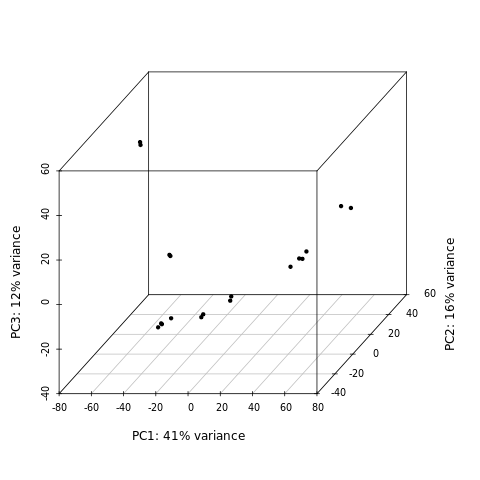

In [168]:
%%R 
library("scatterplot3d")

s = scatterplot3d(
    x=d$PC1 ,y=d$PC2 ,z=d$PC3, 
    xlab = paste0("PC1: ",percentVar[1],"% variance"),
    ylab = paste0("PC2: ",percentVar[2],"% variance"),
    zlab = paste0("PC3: ",percentVar[3],"% variance"),
    pch = 20, labels=d$time,id.n=nrow(d),
    grid=T, box=T
)


> Specify the legend position using `xyz.convert()` 
> 1. The result of scatterplot3d() is assigned to s3d
> 2. The function `s3d$xyz.convert()` is used to specify the coordinates for legends
> 3. the function `legend()` is used to add legends to plots


    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @ Part 4: Run the DESeq tests @
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

- https://hbctraining.github.io/DGE_workshop/lessons/05_DGE_DESeq2_analysis2.html

- https://support.bioconductor.org/p/62684/


In [177]:
%%R 
resultsNames(dds0)

[1] "Intercept" "time"     


In [179]:
%%R 
dds <- DESeq(dds0)
res <- results(dds)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [180]:
%%R 
res %>% head 

log2 fold change (MLE): time 
Wald test p-value: time 
DataFrame with 6 rows and 6 columns
                             baseMean       log2FoldChange               lfcSE
                            <numeric>            <numeric>           <numeric>
ENSG00000000003.15   279.661340149139  -0.0135908030315163 0.00808307421051309
ENSG00000000005.6  0.0977902726711068  0.00537706241069706  0.0761327824924935
ENSG00000000419.12   40.1393504686619  0.00166221634705892 0.00627759236310891
ENSG00000000457.14   17.7307919601938 0.000333641949392757  0.0070187324937486
ENSG00000000460.17   8.78151810885916  -0.0336002652545615  0.0120465477672139
ENSG00000000938.13 0.0891924097100301 -0.00185468459002978  0.0761327824924935
                                  stat              pvalue               padj
                             <numeric>           <numeric>          <numeric>
ENSG00000000003.15   -1.68139035688176  0.0926871173567353  0.209671630418984
ENSG00000000005.6   0.0706274253305693    0

We haven't look into the differential analysis; so, we are stoping the analysis here. Although we could go further to achieve differential experssion hits comparing differrent time points. 

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @ Part 5: enrichment analysis using iPAGE @
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

After getting the `logFC` I usually run iPAGE to find enriched pathways which we are also missing that at this point. 

In [59]:
cat ipage.sh

exp_file=$1;

outdir=${exp_file/.txt/}; outdir=${outdir/_inputs/_results};

echo '______________' $exp_file '>' $outdir '______________';

ipage_ann='/flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/';

mkdir -p $outdir;

for f in `ls -d ${ipage_ann}/mouse*gs*`; do
    base=`basename "$f"`;
    echo '________________' $base '________________';
    
    if [ -d "${outdir}/${base}/" ]; 
    then
        echo 'This result exist!';    
    ## TO-DO; Force run to remove stuff from previous run. 
    else
        # Run iPAGE 
        perl $PAGEDIR/page.pl --expfile=$exp_file \
        --species=$base --exptype=continuous --ebins=11 --nodups=1; 
        wait
        mv -v ${exp_file}_PAGE/ ${outdir}/${base}/;

        # keep complete results 
        pv=${outdir}/${base}/pvmatrix.txt;
        pv0=${pv/.txt/.all.txt}; pvL=${pv/.txt/.L.txt}; pvR=${pv/.txt/.R.txt};

        # subset pathways with p-value > 2 in the first (Left) or last (Right) cluster
        mv -v $pv $pv0;
        cat $pv0 | awk -F'

In [49]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] htmlwidgets_1.5.1           plotly_4.9.1               
 [3] pheatmap_1.0.12             RColorBrewer_1.1-2         
 [5] patchwork_1.0.0             DESeq2_1.20.0              
 [7] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [9] BiocParallel_1.14

In [69]:
%%R 
citation()


To cite R in publications use:

  R Core Team (2018). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {R: A Language and Environment for Statistical Computing},
    author = {{R Core Team}},
    organization = {R Foundation for Statistical Computing},
    address = {Vienna, Austria},
    year = {2018},
    url = {https://www.R-project.org/},
  }

We have invested a lot of time and effort in creating R, please cite it
when using it for data analysis. See also ‘citation("pkgname")’ for
citing R packages.

